# Taconic Parkway, DataFest 2022

Hello, we are team Taconic Parkway from Vassar College. We try to answer 2 central questions in our analysis:

1. Does the game help its players avoid drugs?
2. What is the relationship between play time and efficacy? Is there a "sweet spot"?

Here is our analysis on the dataset, in 3 parts:

1. Exploratory Analysis
2. Statistical Model
3. Conclusion

We hope you enjoy it!

## 1. Exploratory Analysis

In [541]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [542]:
warnings.filterwarnings('ignore')

In [543]:
sns.set_theme()

Let's first take a look at the target variable, drug resistance, in `S5_scores_cleaned.csv`


In [544]:
df_resist = pd.read_csv("Data/S5_scores_cleaned.csv", dtype={'player_id':str}).dropna()

Note: *A higher mean score indicates that the student has lower efficacy in resisting drugs.*

We can invert `S5_mean` to get a resistance score. A higher resistance score means higher efficacy in resisting drugs. A bit more intuitive.

In [545]:
df_resist['resistance'] = 1 / df_resist['S5_mean']

In [546]:
df_resist.head()

,player_id,weeks,S5_mean,resistance
0,6427001,0,3.900,0.256410
1,6427001,3,3.900,0.256410
2,6427001,6,3.875,0.258065
3,6427027,0,3.800,0.263158
4,6427027,3,4.000,0.250000


Some questions we can ask:
- How many weeks does it take for players to complete this game?
- How do the players' drug resistance change over time?

How many weeks does it take for players to complete this game?

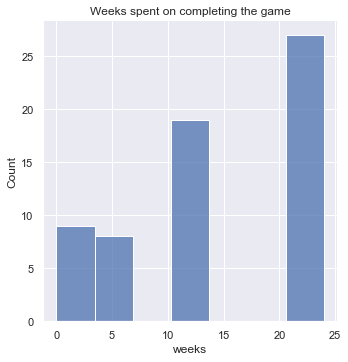

In [547]:
sns.displot(data=df_resist.groupby('player_id').max()['weeks'])
plt.title("Weeks spent on completing the game");

We can see there are 3 groups of players:

- 0-10 weeks
- 10-15 weeks
- 20-25 weeks

How do players' drug resistance change over time for each group?

In [548]:
# 0-5 weeks
player_list_0_5 = df_resist.groupby('player_id').max().query("weeks < 10").index
# 10-15 weeks
player_list_10_15 = df_resist.groupby('player_id').max().query("10 <= weeks < 15").index
# 20-25 weeks
player_list_20_25 = df_resist.groupby('player_id').max().query("20 <= weeks <= 25").index

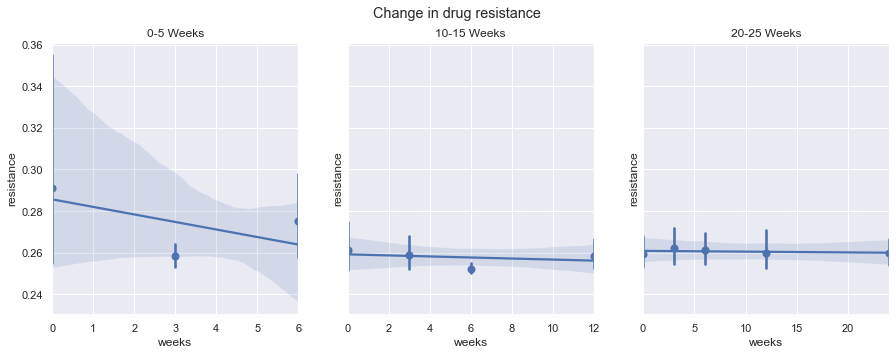

In [549]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

fig.suptitle('Change in drug resistance')
axes[0].set_title('0-5 Weeks')
axes[1].set_title('10-15 Weeks')
axes[2].set_title('20-25 Weeks')

sns.regplot(ax=axes[0], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_0_5)), x_estimator=np.mean)
sns.regplot(ax=axes[1], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_10_15)), x_estimator=np.mean)
sns.regplot(ax=axes[2], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_20_25)), x_estimator=np.mean);

It looks like on average, players who spent the least time completing the game experienced steeper decreases in drug resistance ratings.

***Potential research question: is drug resistance rating associated with playing time in some way?***

Moving on to the main dataset, `logs.csv`

In [550]:
df_log = pd.read_csv("Data/logs.csv", low_memory=False)

This dataset is large, so let's focus on just one player first.

In [551]:
player_a = df_log['player_id'][0]
df_player_a = df_log.query(f"player_id == {player_a}")

This game is divided into 12 scenes ("stacks"). Each with a different theme. See `Spreadsheets\ChallengeStacksData.xlsx` for details on each stack.

In [552]:
# keys are stack ids, values are stack themes
stacks = {
    0: "Cheaters",
    1: "Poolside",
    2: "Kissing",
    3: "Pills",
    4: "Misbehavin'",
    5: "New Year's",
    6: "Serious",
    7: "Racing",
    8: "Scare",
    9: "Prom",
    10: "Confide",
    11: "First Job",
    12: "Tutorial"
}

How long does this player spend on each stack? We can write a function for this:

In [553]:
def stack_play_time(player_id):
    '''
    calculates the amount of time a player spends on each stack
    '''
    df_player = df_log.query(f"player_id == {player_id}")
    play_history = df_player.dropna(subset=['stack_id'])[['stack_id', 'event_time_dbl']].groupby('stack_id').max()
    # need to sort by event_time_dbl because players don't necessarily go through stacks in numerical order
    play_history.sort_values(by='event_time_dbl', inplace=True)
    play_times = play_history.diff()
    play_times.rename(columns={'event_time_dbl': 'play_time'}, inplace=True)
    # we don't care about the tutorial
    play_times.drop(index=12, inplace=True)
    play_times.sort_index(inplace=True)
    play_times['description'] = [stacks[x] for x in play_times.index]
    play_times['player_id'] = player_id
    play_times = play_times[['player_id', 'play_time', 'description']]
    play_times.reset_index(inplace=True)
    play_times['stack_id'] = play_times['stack_id'].astype(int)
    return play_times

In [554]:
stack_play_time(player_a)

,stack_id,player_id,play_time,description
0,0,6427001,3835.0,Cheaters
1,1,6427001,1588.0,Poolside
2,2,6427001,2402.0,Kissing
3,3,6427001,1388.0,Pills
4,4,6427001,1867.0,Misbehavin'
5,5,6427001,3045.0,New Year's
6,6,6427001,2972.0,Serious
7,7,6427001,1925.0,Racing
8,8,6427001,2809.0,Scare
9,9,6427001,1025.0,Prom


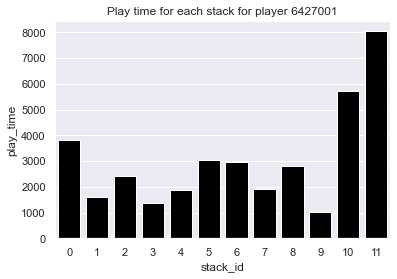

In [555]:
sns.barplot(x='stack_id', y='play_time', data=stack_play_time(player_a), color='black')
plt.title(f"Play time for each stack for player {player_a}");

Now, let's take a look at this metric on an aggregate level.

In [556]:
df_play_time = pd.concat([stack_play_time(player) for player in df_log['player_id'].unique()])

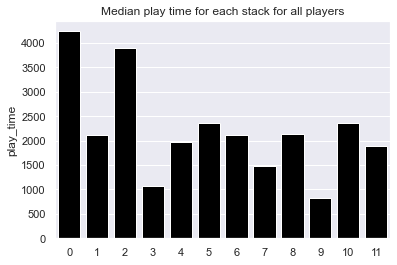

In [557]:
sns.barplot(x=np.arange(12), y='play_time', data=df_play_time.groupby('stack_id').median(), color='black')
plt.title("Median play time for each stack for all players");

We ultimately want to connect play time to drug resistance. So let's dig more into drug-related data.

Some knowledge mini-games have about drugs, in those mini-games, players are prompted to select a fact card they agree with.

We can find fact cards about drugs in `Spreadsheets\KnowledgeMinigameData.xlsx`

In [558]:
df_knowledge = pd.read_excel("Spreadsheets\KnowledgeMinigameData.xlsx", sheet_name='gamedata', header=1, index_col='id')

We are interested in fact cards about drugs. We can look for the keyword "drug" in the descriptions.

In [559]:
for i in range(32): # there are 31 knowledge mini games in total
    if 'drug' in df_knowledge.at[i, 'description']:
        print(f"Factcard ID {i}: {df_knowledge.at[i, 'description']}")

Factcard ID 19: Using drugs not prescribed by a doctor specifically for you can cause serious health problems, even death.
Factcard ID 21: Even using drugs a few times can quickly change to an addiction. 
Factcard ID 22: Using any drug can be more dangerous when taken with alcohol or other drugs.
Factcard ID 26: Teens who drink are more likely to put themselves in situations like unsafe sex and drug use.
Factcard ID 31: Teens who think about their future are less likely to engage in risky behaviors such as doing drugs or drinking alcohol.


We can calculate the time a player spends on drug related mini games.

In [560]:
def drug_mini_levels(player_id):
    drug_fact_cards = ['FactCardData_id:19]', 'FactCardData_id:21]', 'FactCardData_id:22]', 'FactCardData_id:26]', 'FactCardData_id:31]']
    # find out which levels are associated with drugs card by card
    levels = []
    for card in drug_fact_cards:
        df_card = df_log.query(f"player_id=={player_id} & fact_card_id=='{card}'")
        # find out the levels this fact card appears in
        card_levels = df_card['minigame_level'].unique()
        [levels.append(l) for l in card_levels if l not in levels]
    # these are all the drug-related mini game levels for this player
    levels = sorted([int(l) for l in levels])
    return levels

In [561]:
def level_play_time(player_id, level):
    """
    calculates the amount of time a player spends on a certain level of a knowledge mini game
    """
    df_player = df_log.query(f"player_id == {player_id}")
    # event 400 starts mini game 
    # event id 103, 420, 1002, 1003 end mini game
    df_level = df_player.query("event_id == 400 | event_id == 420 | event_id == 1002")
    df_level = df_level.query(f"minigame_level == {level}")
    df_level = pd.concat([df_level, df_player.query("event_id == 103 | event_id == 1003")], axis=0)
    df_level.sort_values(by=['event_time_dbl'], inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # return df_level
    # sometimes players click away and generate new 400 events, so we need to drop the extra 400 events
    
    # after this loop, we will have alternating rows of 400 and (103/420/1002/1003) events
    first_400_idx = df_level.query("event_id == 400").index[0]
    last_400_idx = df_level.query("event_id == 400").index[-1]
    df_level = df_level.loc[first_400_idx:last_400_idx+1]

    df_level.reset_index(drop=True, inplace=True)
    i = 0
    drop = []
    while i < len(df_level)-1:
        # we want all neighboring (400/non-400) pairs
        curr_id = df_level.at[i, 'event_id']
        next_id = df_level.at[i+1, 'event_id']

        if curr_id == 400 and next_id != 400:
            i += 2 # we want this
        else:
            drop.append(i)
            i += 1

    df_level.drop(index=drop, inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # after this loop, we will take out edge cases where the player quit halfway
    k = 1
    drop = []
    while k <= len(df_level)-1:
        # we want all neighboring pairs to be on the same day
        curr_date = df_level.at[k, 'date']
        prev_date = df_level.at[k-1, 'date']
        if curr_date != prev_date:
            drop += [k, k-1]
        k += 2
    
    df_level.drop(index=drop, inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # calculate the play time for each interval
    play_time = 0
    for j in range(1, len(df_level), 2):
        play_start = df_level.at[j-1, 'event_time_dbl']
        play_end = df_level.at[j, 'event_time_dbl']
        # if the player exited in less than a minute, discard this record
        duration = play_end - play_start
        if duration >= 60:
            play_time += duration
    # this is the total amount of time this player spent on this mini game
    return play_time

In [562]:
def drug_mini_play_time(player_id):
    levels = drug_mini_levels(player_id)
    play_time = [level_play_time(player_id, l) for l in levels]
    df_play_time = pd.DataFrame({'player_id':player_id, 'level':levels, 'play_time':play_time})
    return df_play_time

For our player, the play time for all drug-related mini games is:

In [563]:
drug_mini_play_time(player_a)

,player_id,level,play_time
0,6427001,1,447
1,6427001,2,999
2,6427001,3,879
3,6427001,5,1706


Stack 3 is also about drugs. Stack 3 play time for our player is:

In [564]:
stack_play_time(player_a).query("stack_id == 3")['play_time'].values[0]

1388.0

We can get our player's total drug-related play time by adding the mini game play time to the stack 3 play time:

In [565]:
def total_drug_play_time(player_id):
    stack_3 = stack_play_time(player_a).query("stack_id == 3")['play_time'].values[0]
    mini_game = drug_mini_play_time(player_id)['play_time'].sum()
    return stack_3 + mini_game

In [566]:
total_drug_play_time(player_a)

5419.0

What about all players?

In [567]:
all_players = list(df_log['player_id'].unique())
# this takes about 2 minutes
df_drug_play_time = pd.DataFrame({'player_id':all_players, 'drug_play_time':[total_drug_play_time(p) for p in all_players]})

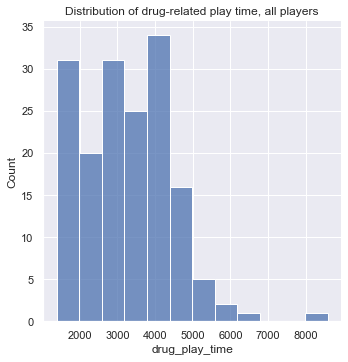

In [568]:
sns.displot(x='drug_play_time', data=df_drug_play_time)
plt.title("Distribution of drug-related play time, all players");

What we really want to do is to make this play time cumulative so we get a time-series of each player's drug-related play time as the player progresses through the game.

Another thing we can try to figure out is how much time each player spent on each mini game.

In [571]:
df_player_a.sort_values(by=['event_time_dbl'], inplace=True)

In [965]:
def mini_play_time_v2(player_id):
    # initialize two dictionaries that contains game play times
    cumulative_play_time = {
        'knowledge': {x:0 for x in range(10)},
        'priority': {x:0 for x in range(10)},
        'people': {x:0 for x in range(10)},
        'refusal': {x:0 for x in range(10)}
    }

    completion_time = {
        'knowledge': {x:0 for x in range(10)},
        'priority': {x:0 for x in range(10)},
        'people': {x:0 for x in range(10)},
        'refusal': {x:0 for x in range(10)}
    }

    # filter out data about this player
    df_player = df_log.query(f"player_id == {player_id}")
    player_events = df_player['event_id']
    # look for all 1003 events
    event_1003 = player_events[player_events == 1003]
    # iteratively go through all 1003 events
    for i in event_1003.index:
        # check if next row is 1004
        if player_events[i+1] == 1004:
            # if next row != 1004, we don't care about this entry
            # if next row == 1004, this means the player has chosen to start the mini game
            # log current time to "start the stopwatch"
            start_time = df_player.at[i, 'event_time_dbl']
            curr_type = ''
            # get minigame_id in the 1003 row (0=Knowledge, 1=Priority, 2=People, 3=Refusal)
            minigame_id = df_player.at[i, 'minigame_id']
            if minigame_id == 0:
                curr_type = 'knowledge'
            elif minigame_id == 1:
                curr_type = 'priority'
            elif minigame_id == 2:
                curr_type = 'people'
            elif minigame_id == 3:
                curr_type = 'refusal'
            # get minigame_level in the 1004 row
            curr_level = int(df_player.at[i+1, 'minigame_level'])

            # what does the player do next?
            def get_next_action(curr_idx, next_symbols):
                remaining_actions = player_events.loc[curr_idx:]
                remaining_actions = remaining_actions[remaining_actions.isin(next_symbols)]
                next_action = remaining_actions.values[0]
                next_action_idx = remaining_actions.index[0]
                return next_action_idx, next_action
            
            next_action_idx, next_action = get_next_action(i, [103, 1002, 1005])

            # if player leaves game (103/1002), store how much time is spent on this game
            if next_action in [103, 1002]:
                end_time = df_player.at[next_action_idx, 'event_time_dbl']
                duration = end_time - start_time
                # if this session lasted longer than 60 seconds, record this
                if duration >= 60:
                    cumulative_play_time[curr_type][curr_level] += duration
            # if player completes the game (1005), we want to look for the next (103/1002/1001)
            # in other words, where the player exited the game by completing it or quitting
            elif next_action == 1005:
                next_action_idx, next_action = get_next_action(next_action_idx, [103, 1002, 1001])
                end_time = df_player.at[next_action_idx, 'event_time_dbl']
                duration = end_time - start_time
                cumulative_play_time[curr_type][curr_level] += duration
                # the next action is 1001, this means the player has completed the game
                if next_action == 1001:
                    completed_on = end_time
                    # updated if this is larger than the current entry
                    if completed_on > completion_time[curr_type][curr_level]:
                        completion_time[curr_type][curr_level] = completed_on
    
    # package everything into a dataframe
    rtn_idx = []
    for game_type in ['kn', 'pr', 'pe', 're']:
        for level in range(10):
            rtn_idx.append(game_type + f'{level}')
    df_rtn = pd.DataFrame(columns=['player_id', 'type', 'level', 'play_time', 'completed_on'], index=rtn_idx)
    # unpack the first dictionary with information about play time
    for game_type, levels in cumulative_play_time.items():
        for level, play_time in levels.items():
            idx = game_type[:2] + str(level)
            df_rtn.at[idx, 'type'] = game_type
            df_rtn.at[idx, 'level'] = level
            df_rtn.at[idx, 'play_time'] = play_time
    # unpack the second dictionary with information about completion time
    for game_type, levels in completion_time.items():
            for level, completed_on in levels.items():
                idx = game_type[:2] + str(level)
                df_rtn.at[idx, 'completed_on'] = completed_on
    df_rtn['player_id'] = player_id
    df_rtn.reset_index(inplace=True, drop=True)
    df_rtn = df_rtn[df_rtn['completed_on'] != 0]
    df_rtn.sort_values(by=['completed_on'], inplace=True)

    return df_rtn

In [1034]:
def mini_play_time(player_id):
    # initialize return dataframe
    rtn_idx = []
    for game_type in ['kn', 'pr', 'pe', 're']:
        for level in range(10):
            rtn_idx.append(game_type + f'{level}')
    df_rtn = pd.DataFrame(
        columns=['player_id', 'game_type', 'game_level', 'play_time', 'last_interaction'], 
        index=rtn_idx,
        data={
            'player_id':player_id, 
            'game_type':['knowledge']*10 + ['priority']*10 + ['people']*10 + ['refusal']*10,
            'game_level':list(range(10))*4,
            'play_time':[0]*40,
            'completed_on':[0]*40
            }
        )
    # initialize event log dataframe
    df_sessions = pd.DataFrame(columns=['session_id', 'status', 'event_id', 'row_id', 'time', 'game'])

    # only keep data about this player
    df_player = df_log.query(f"player_id == {player_id}")
    player_events = df_player['event_id']

    # an event 1003 followed by event 1004 indicates game start
    event_1003 = player_events[player_events == 1003]
    session_starts = []
    for idx_1003 in event_1003.index:
        if df_player.at[idx_1003+1, 'event_id'] == 1004:
            session_starts.append(idx_1003)
    
    for i in range(len(session_starts)):
        
        curr_idx = session_starts[i] # this is the index of event 1003
        start_time = df_player.at[i, 'event_time_dbl']
        # get minigame_id in the 1003 row (0=Knowledge, 1=Priority, 2=People, 3=Refusal)
        minigame_id = df_player.at[i, 'minigame_id']
        curr_type = ''
        if minigame_id == 0:
            curr_type = 'kn'
        elif minigame_id == 1:
            curr_type = 'pr'
        elif minigame_id == 2:
            curr_type = 'pe'
        elif minigame_id == 3:
            curr_type = 're'
        # get minigame_level in the 1004 row
        curr_level = int(df_player.at[curr_idx+1, 'minigame_level'])
        game = curr_type + str(curr_level)

        # log this into the session dataframe
        df_sessions = pd.concat([
            df_sessions,
            pd.DataFrame(
                data={'session_id':i, 
                'status':'enter',
                'event_id':1003,
                'row_id':df_player.at[curr_idx, 'row_id'],
                'time':start_time,
                'game':game},
                index=[0])], 
            ignore_index=True)

        # window to look for a session end
        if i == len(session_starts)-1:
            events_window = player_events[i:]
        else:
            events_window = player_events[session_starts[i]:session_starts[i+1]]

        # events (103/1002/1001) end the session
        session_ends = [103, 1002, 1001]
        for e_idx in events_window.index:
            if  events_window[e_idx] in session_ends:
                # log this into the session dataframe
                df_sessions = pd.concat([df_sessions,
                    pd.DataFrame({'session_id':i, 
                    'status':'exit',
                    'event_id':events_window[e_idx],
                    'row_id':df_player.at[e_idx, 'row_id'],
                    'time':df_player.at[e_idx, 'event_time_dbl'],
                    'game':game})], ignore_index=True)
                # calculate session duration
                end_time = df_player.at[e_idx, 'event_time_dbl']
                duration = start_time - end_time
                # if the player stayed for at least 60 seconds, update this
                if duration >= 60:
                    # variable game is an index, e.g. kn0 for Knowledge Level 0
                    df_rtn.at[game, 'play_time'] += duration
                    df_rtn.at[game, 'last_interaction'] = end_time
                break
    return df_rtn, df_sessions


In [1035]:
a_r, a_s = mini_play_time(player_a)

ValueError: If using all scalar values, you must pass an index

In [964]:
df_player_a.to_csv("player_a.csv", index=False)

In [963]:
mini_play_time(player_a)

,player_id,type,level,play_time,completed_on
10,6427001,priority,0,705,2307
20,6427001,people,0,895,3948
0,6427001,knowledge,0,1127,4667
11,6427001,priority,1,99,6561
34,6427001,refusal,4,162,7696
30,6427001,refusal,0,499,9218
33,6427001,refusal,3,282,9682
31,6427001,refusal,1,496,10057
22,6427001,people,2,289,11490
12,6427001,priority,2,169,11706


In [959]:
irregular_players = []
player_histories = []

for p in df_log['player_id'].unique():
    try:
        player_histories.append(mini_play_time(p))
    except:
        irregular_players.append(p)

print(f"Number of irregular players: {len(irregular_players)}.")

Number of irregular players: 10.


In [960]:
df_all_players = pd.concat(player_histories, ignore_index=True)

In [962]:
df_all_players.to_csv("all_players.csv", index=False)

6486015


<AxesSubplot:ylabel='play_time'>

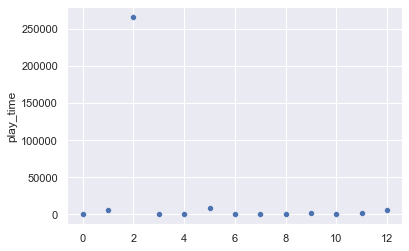

In [1009]:
player = df_all_players['player_id'].sample().values[0]
print(player)
sns.scatterplot(x=np.arange(len(df_all_players.query(f"player_id == {player}"))),
                y='play_time',
                data=df_all_players.query(f"player_id == {player}"))

In [779]:
def mini_play_time(player_id):
    df_player = df_log.query(f"player_id == {player_id}")
    player_events = df_player['event_id']
    # look for events where players start the mini game
    begin_events = df_player.query("event_id==400 | event_id==500 | event_id==800 | event_id==900")
    exit_events = df_player.query("event_id==103 | event_id==1000 | event_id==1001 | event_id==1002") 
    
    key_events = pd.concat([begin_events, exit_events], axis=0)
    key_events.sort_values(by=['event_time_dbl'], inplace=True)
    
    begin_ids = [400, 500, 800, 900]
    end_ids = [103, 1000, 1001, 1002]
    status = []
    for e in key_events['event_id']:
        if e in begin_ids:
            status.append('enter')
        else:
            status.append('exit')
    key_events['status'] = status

    keep_rows = [True]
    for i in range(len(key_events.index)-1):
        curr_idx = key_events.index[i]
        next_idx = key_events.index[i+1]
        if key_events.at[curr_idx, 'status'] == key_events.at[next_idx, 'status']:
            keep_rows.append(False)
        else:
            keep_rows.append(True)
    
    key_events = key_events.loc[keep_rows]
    if key_events['event_id'].values[0] in end_ids:
        key_events = key_events.iloc[1:]
    elif key_events['event_id'].values[-1] in begin_ids:
        key_events = key_events.iloc[:-1]
    
    game_type = []
    for c in key_events['event_category']:
        if c in ['People Sense', 'Knowledge Minigame', 'Refuse Power Minigame', 'Priority Sense']:
            game_type.append(c)
        else:
            game_type.append(game_type[-1])
    key_events['game_type'] = game_type

    # keep the columns we are interested in
    key_events = key_events[['row_id', 'player_id', 'date', 'event_time_dbl', 'stack_id', 'game_type', 'status']]

    return key_events

In [814]:
def find_stack_flow(player_id):
  # find the data for this player from the full log data
  df_p = df_log[df_log['player_id']==player_id]

  # find data relevant to stack-related events
  def find_stack_event(df):
    rel = df[(df['event_id'] == 200) | (df['event_id'] == 203) | (df['event_id'] == 204) | (df['event_id']==1)|(df['event_id']==101)|(df['event_id']==1002)]
    rel = rel.sort_values(by = 'event_time_dbl', ascending = True)
    rel = rel[['row_id', 'player_id','date','event_id','event_description','stack_id','stack_title','event_time_dbl']]
    return rel
  
  df_stack = find_stack_event(df_p)

  def find_status(event_id):
    if event_id == 200:
      return 'enter'
    elif event_id in [204, 1, 101, 1002]:
      return 'exit'
    elif event_id == 203:
      return 'complete'
  
  df_stack['status'] = df_stack['event_id'].apply(find_status)
  df_stack['status'] = df_stack['status'].apply(lambda x: 'exit' if x == 'complete' else x)
  # df_stack['status_dum'] = df_stack['event_id'].apply(find_status_dum)

  # drop multiple exits and keep the first one
  index_to_drop = []
  for i in range(1,len(df_stack)):
    if df_stack['status'].iloc[i] == 'exit' and df_stack['status'].iloc[i-1] == 'exit':
      index_to_drop.append(i)
    if pd.isna(df_stack['stack_id'].iloc[i]):
      df_stack['stack_id'].iloc[i] = df_stack['stack_id'].iloc[i-1]

  df_stack = df_stack.drop(df_stack.index[index_to_drop])
  df_stack = df_stack[df_stack['stack_id'] != 12]
  return df_stack[['row_id','player_id','date','stack_id','stack_title','event_time_dbl','status']]

## 2. Statistical Model

We want to run a simple linear regression on each individual player. The y-variable is the time spent on a mini game, and the x-variable is the time at which the player completes the mini game.

## 3. Conclusion